In [1]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

In [2]:
# 2.1
# add an empty dimension and scale the images to values between 0 and 1
normalize = lambda x: tf.cast(tf.expand_dims(x, -1), tf.float32) / 255.

# add random noise to the image and keep the image values between 0 and 1  
add_noise = lambda x, e: tf.clip_by_value(x + e * tf.random.normal(mean=0., stddev=1., shape=x.shape),
                                          clip_value_min=0.,
                                          clip_value_max=1.)

# other preprocessing steps
def prepare_data(ds, noise_level=0.4, batch_size=32):
    # apply lambda functions
    ds = ds.map(lambda x,t: (normalize(x), normalize(t)))
    ds = ds.map(lambda x,t: (add_noise(x, noise_level), t))
    
    # shuffle, batch, prefetch
    ds = ds.cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return ds
 
def plot_images(ds, img_size=(28,28)):
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(22,5))

    for noisy_images, original_images in ds.take(1):
        for i in range(10): 
            ax[0,i].imshow(noisy_images[i].numpy().reshape(img_size))
            ax[0,i].set(title='noisy image')
            ax[1,i].imshow(original_images[i].numpy().reshape(img_size))
            ax[1,i].set(title='original image')

    plt.show();

11490434/11490434 [==============================] - 0s 0us/step


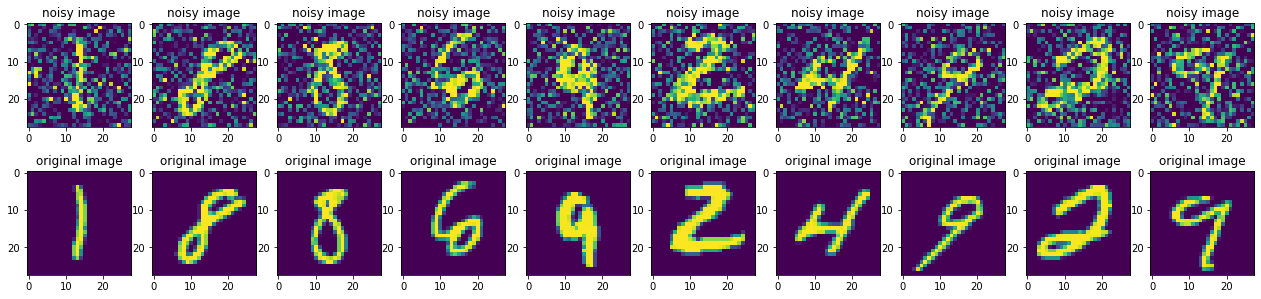

In [3]:
# load the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# set the originial images as targets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test))

# prepare the dataset
train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

# plot the noisy images and the original target images
plot_images(train_ds)

In [4]:
# 2.2.1
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout

class Encoder(tf.keras.layers.Layer):
    '''
    encoder class which reduces the size of our feature map
    '''
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        # layers for our encoder
        self.layer_list =  [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu', input_shape=(28,28,1)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(latent_dim, activation='sigmoid')]

    def call(self, x , training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [5]:
from keras.layers import Conv2DTranspose

class Decoder(tf.keras.Model):
    '''
    decoder taking the embedding from the encoder as input to reshape the resulting vector into feature maps again
    '''
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        # layers for the decoder: here we use Conv2DTranspose 
        self.layer_list =  [tf.keras.layers.Dense(3136, activation='relu', input_shape=(latent_dim,)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Reshape((7,7,64)),
                            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid')]

    def call(self, x , training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [6]:
class Autoencoder(tf.keras.Model):
    '''
    autoencoder consisting of encoder and decoder
    '''
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.BinaryAccuracy(name="acc")]

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x, training=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded       

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function 
    def train_step(self, data):
        x, t = data
        
        with tf.GradientTape() as tape:
            output = self(x, training = True)
            loss = self.compiled_loss(t, output, regularization_losses=self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(t, output)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, t = data
        
        output = self(x, training=False)
        loss = self.compiled_loss(t, output, regularization_losses=self.losses)
                
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(t, output)
        
        return {m.name : m.result() for m in self.metrics}

In [7]:
model = Autoencoder(15)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

# compile the model
model.compile(optimizer=optimizer, loss=loss)

In [8]:
EXPERIMENT_NAME = "denoising_autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [9]:
# 2.3
# lets train our model 
history = model.fit(train_ds,
                    validation_data=test_ds,
                    initial_epoch=0,
                    epochs=10,
                    callbacks=[logging_callback])

Epoch 1/10
1875/1875 [==============================] - 237s 124ms/step - loss: 0.1665 - acc: 0.7978 - val_loss: 0.1227 - val_acc: 0.8091
Epoch 2/10
1875/1875 [==============================] - 240s 128ms/step - loss: 0.1247 - acc: 0.8091 - val_loss: 0.1217 - val_acc: 0.8093
Epoch 3/10
1875/1875 [==============================] - 232s 124ms/step - loss: 0.1209 - acc: 0.8097 - val_loss: 0.1197 - val_acc: 0.8086
Epoch 4/10
1875/1875 [==============================] - 234s 125ms/step - loss: 0.1188 - acc: 0.8101 - val_loss: 0.1167 - val_acc: 0.8073
Epoch 5/10
1875/1875 [==============================] - 218s 116ms/step - loss: 0.1177 - acc: 0.8102 - val_loss: 0.1143 - val_acc: 0.8099
Epoch 6/10
1875/1875 [==============================] - 203s 108ms/step - loss: 0.1166 - acc: 0.8104 - val_loss: 0.1114 - val_acc: 0.8103
Epoch 7/10
1875/1875 [==============================] - 200s 107ms/step - loss: 0.1160 - acc: 0.8105 - val_loss: 0.1153 - val_acc: 0.8076
Epoch 8/10
1875/1875 [============

In [10]:
# visualize the loss and accuracy of our model 
def visualize_training(history):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].legend(labels=["training loss","validation loss"])

    ax[1].plot(history.history["acc"])
    ax[1].plot(history.history["val_acc"])
    ax[1].legend(labels=["training accuracy","validation accuracy"])

# plot some images with their reconstructed couterparts
def show_reconstructions(model, ds, img_size=(28,28)):
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,8))
    
    for noisy_images, original_images in test_ds.take(1):
        reconstructions = model(noisy_images, training=False)
        for i in range(5):
            ax[0,i].imshow(noisy_images[i].numpy().reshape(img_size))
            ax[0,i].set(title='noisy image')
            ax[1,i].imshow(original_images[i].numpy().reshape(img_size))
            ax[1,i].set(title='original image')
            ax[2,i].imshow(reconstructions[i].numpy().reshape(img_size))
            ax[2,i].set(title='denoised image')

In [74]:
#2.4
from sklearn.manifold import TSNE

# embed the first 1000 images of the test set using the encoder
data = normalize(X_test[:1000])
labels = y_test[:1000]
embedding = model.encoder(data)
tsne = TSNE(n_components=2, perplexity = 20).fit_transform(embedding)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


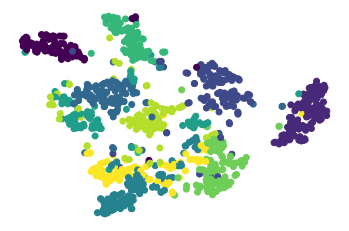

In [75]:
# plot the data points, coloured according to their class
plt.scatter(tsne[:,0], tsne[:,1], c=labels)
plt.axis("off")
plt.show();

The t-SNE algorithm is a dimensionality reduction method that maps the data to a lower dimensionality. For this purpose, the distance between the data points is measured and the data points are mapped to a lower dimension with respect to this distance. However, this does not preserve the global structure, only the local structure. For our example, this means that the same values should form clusters/shapes. All 1's could form the purple cluster and all 7's could form the light green cluster.  
However, it is difficult to interpret the distance between digits that are not similar or where it is difficult to compare multiple clusters. One might think that similar digits such as the six, the eight, and the three are close together in latent space and the seven is farther away, but this structure is not preserved by the t-SNE. 

In [13]:
#  interpolate linearly between the embeddings of a seven and a one
ipn = [embedding[0] * i * .1 + embedding[2] * (10 - i) * .1 for i in range(10)]
reconstructed = model.decoder(tf.convert_to_tensor(ipn))

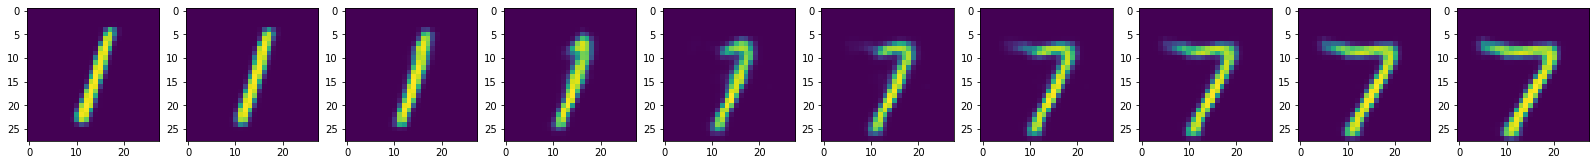

In [14]:
# plot the reconstructed images
plt.figure(figsize=(28,7))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(reconstructed[i].numpy().reshape((28,28)))